[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Neuromorphic Datasets with Tonic + snnTorch
## Tutorial 7
### By Gregor Lenz (lenzgregor.com) and Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/examples/tutorial_7_neuromorphic_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

# 简介
在本教程中，您将
* 学习如何使用 [Tonic](https://github.com/neuromorphs/tonic) 加载神经形态数据集
* 利用缓存加快数据加载速度
* 使用 [Neuromorphic-MNIST](https://tonic.readthedocs.io/en/latest/datasets.html#n-mnist) 数据集训练 CSNN

如果在 Google Colab 中运行：
* 您可以通过检查 `Runtime` > `Change runtime type` > `Hardware accelerator： GPU`
* 接下来，点击下面的单元格并按`Shift+Enter`键，安装 snnTorch 和 Tonic 的最新 PyPi 发行版。

In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet

# 1. 使用 Tonic 加载神经形态数据集
得益于 [Tonic](https://github.com/neuromorphs/tonic)，从神经形态传感器加载数据集变得非常简单，它的工作原理与 PyTorch 视觉非常相似。

让我们首先加载 MNIST 数据集的神经形态版本，称为 [N-MNIST](https://tonic.readthedocs.io/en/latest/reference/datasets.html#n-mnist)。 我们可以查看一些原始事件来了解我们正在处理的内容。

In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

c:\Users\qq491\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1011894272it [04:18, 3908059.34it/s]                                


Extracting ./data\NMNIST\train.zip to ./data\NMNIST
[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


每行对应一个事件，由四个参数组成：（*x 坐标、y 坐标、时间戳、极性*）。

* x 和 y 坐标对应于 $34 \times 34$ 网格中的地址。

* 事件的时间戳以微秒为单位记录。

* 极性是指是否发生正尖峰（+1）或离尖峰（-1）； 即，亮度增加或亮度降低。

如果我们将这些事件随时间推移累积起来，并绘制成图像，看起来就像这样：

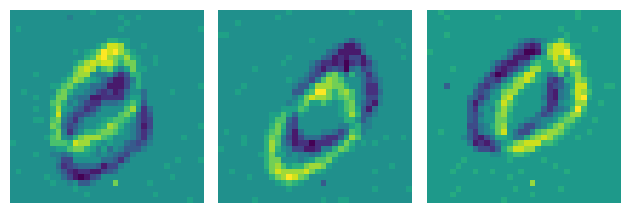

In [3]:
tonic.utils.plot_event_grid(events)

## 1.1 转换

然而，神经网络不能把事件列表作为输入。原始数据必须转换为合适的表示形式，例如张量。 在将数据输入网络之前，我们可以选择一组应用于数据的转换。 举个例子，神经形态相机传感器的时间分辨率为微秒，当转换为密集表示时，最终会成为一个非常大的张量。 这就是为什么我们使用 [ToFrame 转换](https://tonic.readthedocs.io/en/latest/reference/transformations.html#frames) 将事件分成较少数量的帧，这会降低时间精度，但也允许我们以密集格式使用它。

* `time_window=1000` 将事件集成到 1000 $~\mu$ s 中

* 去噪消除独立的，一次性事件。 如果在 `filter_time` 微秒内 1 像素的邻域内没有发生任何事件，则该事件将被过滤。 较小的 `filter_time` 将过滤更多事件。

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

169675776it [00:11, 14599564.47it/s]                               


Extracting ./data\NMNIST\test.zip to ./data\NMNIST


In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

866 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 866 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

## 1.2 快速数据加载

原始数据的存储格式读取速度较慢。为了加快数据加载速度，我们可以使用磁盘缓存和批处理。这意味着，一旦文件从原始数据集加载，它们就会被写入磁盘。

由于事件记录有不同的长度，我们将提供一个整理函数 `tonic.collation.PadTensors()` 来填充较短的记录，以确保批次中的所有样本具有相同的尺寸。

In [7]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

2.33 ms ± 112 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 2.33 ms ± 112 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

通过使用磁盘缓存和支持多线程和批处理的 PyTorch 数据加载器，大大缩短了加载时间。

如果你有大量可用内存，可以尝试把通过缓存加载到主内存而不是磁盘上来进一步加快数据的加载速度：

```
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)
```

# 2. 利用从事件中创建的帧来训练我们的网络

现在，让我们在 N-MNIST 分类任务中实际训练一个网络。我们首先要定义缓存封装器和数据加载器。同时，我们还要对训练数据进行一些增强。

我们从缓存数据集获得的样本是帧，因此我们可以利用 PyTorch Vision 来应用我们想要的任何随机变换。

In [10]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

现在小批量具有维度（时间步长、批量大小、通道、高度、宽度）。  时间步数将使用小批量中最长记录的时间间隔，所有其他样本将用零填充以匹配它。

In [11]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([311, 128, 2, 34, 34])


## 2.1 定义我们的网络

我们将使用 snnTorch + PyTorch 构建一个 CSNN，就像之前的教程一样。要使用的卷积网络架构是：12C5-MP2-32C5-MP2-800FC10

- `12C5` 是一个  5 $\times$ 5 的卷积核，有 12 个滤波器
- `MP2` 是一个 2 $\times$ 2 最大池化函数
- `800FC10` 是一个全连接层，将 800 个神经元映射到 10 个输出端


In [12]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [14]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

## 2.2 训练

在上一教程中，交叉熵损失被应用于总尖峰计数，以最大化来自正确类别的尖峰数。

`snn.functional` 模块的另一个选项是指定来自正确和不正确类别的目标尖峰数。下面的方法使用了 "均方误差尖峰计数损失"（*Mean Square Error Spike Count Loss*），其目标是在 80% 的时间内从正确类中激发尖峰，在 20% 的时间内从错误类中激发尖峰。鼓励不正确的神经元不产生尖峰可以避免神经元死亡。

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

训练神经形态数据的成本很高，因为它需要依次迭代许多时间步（N-MNIST 数据集约有 300 个时间步）。下面的模拟将耗费一些时间，因此我们将坚持训练 50 次迭代（大约是一个完整训练过程的 1/10）。如果时间充裕，可以随意更改 `num_iters`。由于我们在每次迭代时都会打印结果，因此结果会比较吵，不过也需要等待一段时间才能开始看到任何改进。

在自己的实验中，大约经过 20 次迭代后我们才看到任何改进，而在 50 次迭代后，我们成功地破解了 ~60% 的准确率。

> 警告：下面的模拟将耗费一段时间。去给自己冲杯咖啡，或者..... 十杯。

In [16]:
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 10.94%

Epoch 0, Iteration 1 
Train Loss: 31.00
Accuracy: 10.16%

Epoch 0, Iteration 2 
Train Loss: 30.90
Accuracy: 8.59%

Epoch 0, Iteration 3 
Train Loss: 30.90
Accuracy: 8.59%

Epoch 0, Iteration 4 
Train Loss: 24.56
Accuracy: 10.94%

Epoch 0, Iteration 5 
Train Loss: 12.64
Accuracy: 7.03%

Epoch 0, Iteration 6 
Train Loss: 15.33
Accuracy: 17.97%

Epoch 0, Iteration 7 
Train Loss: 17.16
Accuracy: 14.84%

Epoch 0, Iteration 8 
Train Loss: 17.31
Accuracy: 17.19%

Epoch 0, Iteration 9 
Train Loss: 14.51
Accuracy: 19.53%

Epoch 0, Iteration 10 
Train Loss: 13.05
Accuracy: 21.09%

Epoch 0, Iteration 11 
Train Loss: 13.83
Accuracy: 16.41%

Epoch 0, Iteration 12 
Train Loss: 15.05
Accuracy: 25.78%

Epoch 0, Iteration 13 
Train Loss: 12.68
Accuracy: 18.75%

Epoch 0, Iteration 14 
Train Loss: 12.35
Accuracy: 23.44%

Epoch 0, Iteration 15 
Train Loss: 12.67
Accuracy: 21.09%

Epoch 0, Iteration 16 
Train Loss: 12.69
Accuracy: 31.25%

Epoch 0, I

# 3. 结果
## 3.1 绘图测试精度

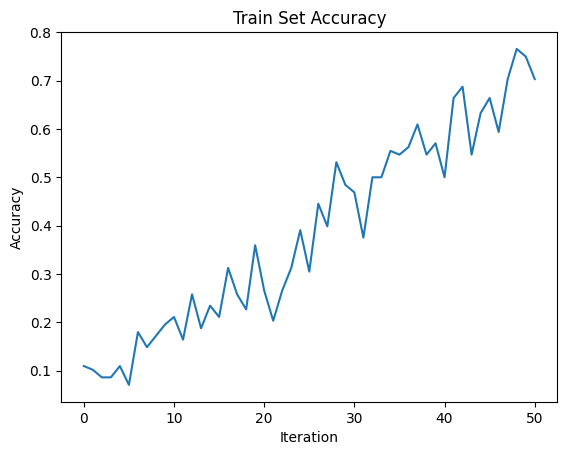

In [17]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 3.2 尖峰计数器

对一批数据进行前向传递，以获得尖峰记录。

In [18]:
spk_rec = forward_pass(net, data)

更改 `idx` 可以对迷你批中的各种样本进行索引。使用 `splt.spike_count` 来探索几个不同样本的尖峰行为。生成以下动画需要一些时间。

> 注意：如果您在本地桌面上运行笔记本，请取消下面一行的注释并修改 ffmpeg.exe 的路径


The target label is: 4


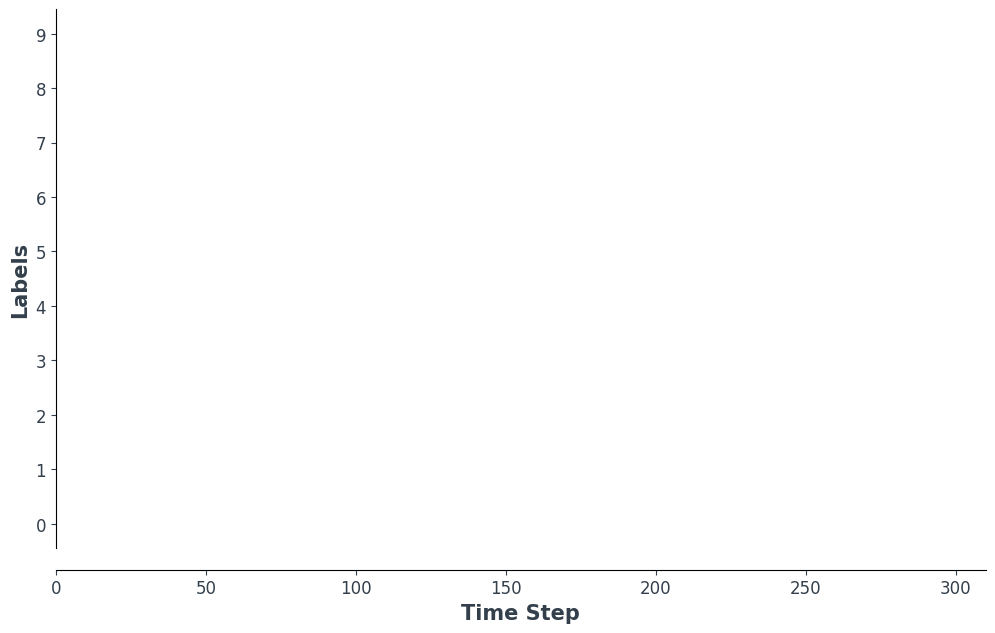

In [19]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

plt.rcParams['animation.ffmpeg_path'] = 'D:\\GoodApp\\ffmpeg\\bin\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# 结论
如果你做到了这一步，那么恭喜你--你拥有僧侣般的耐心。你现在应该也了解了如何使用 Tonic 加载神经形态数据集，然后使用 snnTorch 训练网络。

深度挖掘系列教程到此结束。

请访问 [高级教程](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) 了解更多高级技术，例如在 SNN 中引入长期时间动态、种群编码或在智能处理单元上加速。

如果您喜欢这个项目，请考虑在 GitHub 上的 repo ⭐ 星级，因为这是最简单、最好的支持方式。


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [The Tonic GitHub project can be found here.](https://github.com/neuromorphs/tonic)
* The N-MNIST Dataset was originally published in the following paper: [Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.  “Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades", Frontiers in Neuroscience, vol.9, no.437, Oct. 2015.](https://www.frontiersin.org/articles/10.3389/fnins.2015.00437/full)
* For further information about how N-MNIST was created, please refer to [Garrick Orchard's website here.](https://www.garrickorchard.com/datasets/n-mnist)